In [1]:
import tensorflow as tf

import pathlib
from typing import Any,Union

2022-09-20 19:35:53.630623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 19:35:53.852840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 19:35:53.852860: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-20 19:35:53.878657: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 19:35:56.779223: W tensorflow/stream_executor/platform/de

In [2]:
def get_dataset_dir(path) -> str:
    return pathlib.Path(path)


In [3]:
BATCH_SIZE:int  = 64
IMG_HEIGHT:int  = 180
IMG_WIDTH:int   = 180
VAL_SPLIT:float = 0.2

In [4]:
def load_dataset(dir) -> Union[list | Any, list | Any]:
  train_ds = tf.keras.utils.image_dataset_from_directory(
    dir,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)
  val_ds = tf.keras.utils.image_dataset_from_directory(
    dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)
  return train_ds, val_ds

# Import dataset

In [5]:
data_dir:str = get_dataset_dir('dataset')
print("Nombres d'image: {}".format(len(list(data_dir.glob('*/*.jpg')))))

Nombres d'image: 921


In [6]:
train_ds, val_ds = load_dataset(data_dir)
class_names = train_ds.class_names
print(class_names)

Found 999 files belonging to 5 classes.
Using 800 files for training.
Found 999 files belonging to 5 classes.
Using 199 files for validation.
['painting', 'photo', 'schematics', 'sketch', 'text']


2022-09-20 19:36:00.147595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-20 19:36:00.147622: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 19:36:00.147658: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Kali): /proc/driver/nvidia/version does not exist
2022-09-20 19:36:00.147870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# View dataset

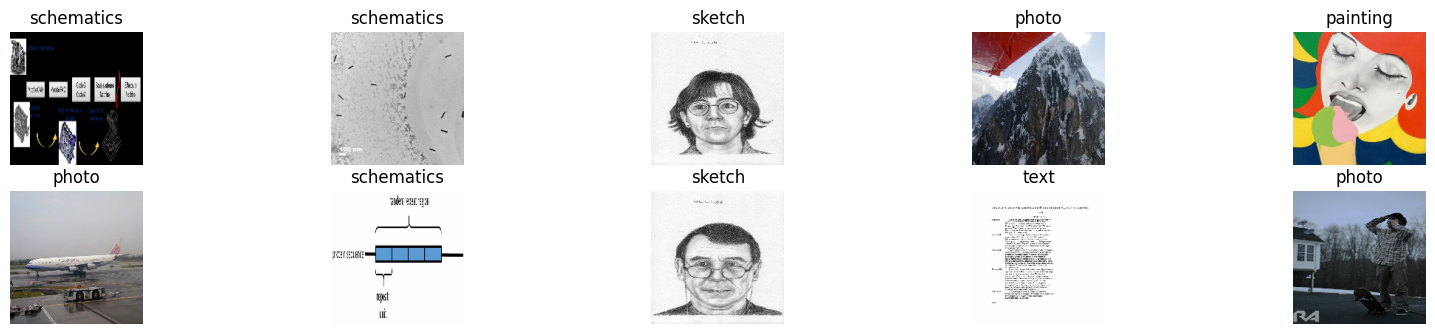

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure the dataset for performance

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(10).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Def model and compile

In [9]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(516, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(516, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer='adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                    

# Train

In [10]:
EPOCHS=2

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True,mode="min")

history:tf.keras.callbacks.History = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
  #,callbacks=es_callback
)

Epoch 1/2
13/13 [==============================] - 17s 1s/step - loss: 1.6330 - accuracy: 0.2013 - val_loss: 1.6033 - val_accuracy: 0.1910
Epoch 2/2
13/13 [==============================] - 12s 954ms/step - loss: 1.5797 - accuracy: 0.2087 - val_loss: 1.5812 - val_accuracy: 0.2663


# Vis training

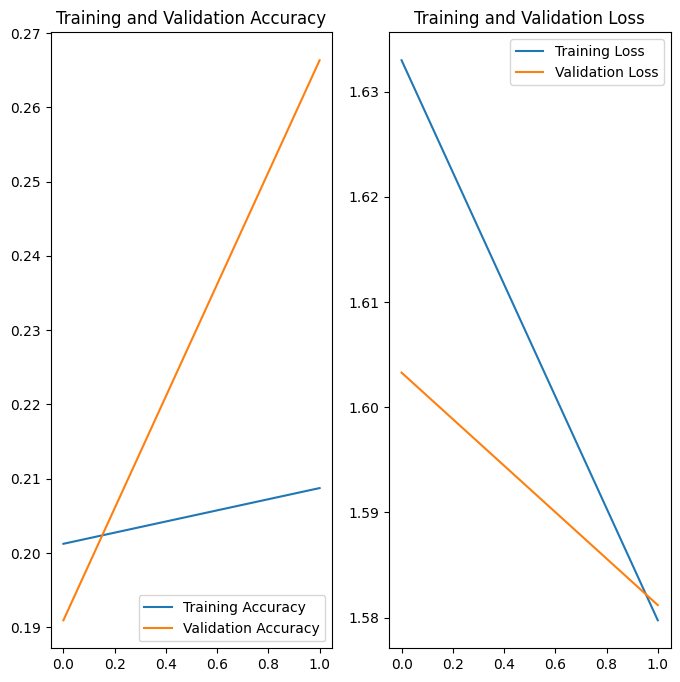

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Save

In [13]:
import datetime

date:datetime = datetime.datetime.now().strftime("%m.%d.%Y_%H:%M:%S")
model_dir:str = f"model_{date}"
model.save(model_dir)
f = open(f"{model_dir}/model_summary.txt", "a")
f.write(model.summary(print_fn=lambda x: fh.write(x + '\n')))
f.close()

INFO:tensorflow:Assets written to: model_09.20.2022_19:43:33/assets


INFO:tensorflow:Assets written to: model_09.20.2022_19:43:33/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 16)       0         
 2D)                                                    

TypeError: write() argument must be str, not None